## Environment preparation

Google Cloud Platform was used for the execution of this analysis.

The steps followed for the preparation are the ones below:

A cluster was created with the following specifications.

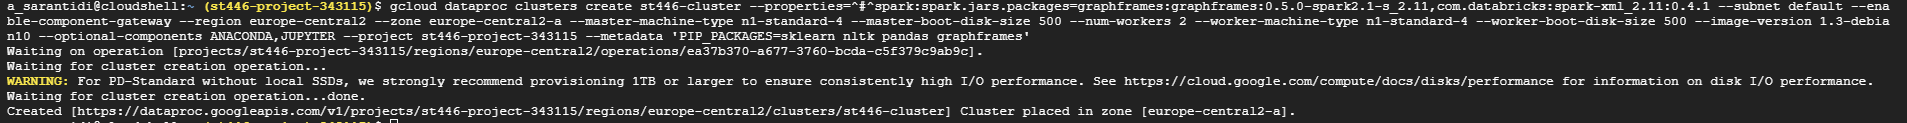


A bucket was created, so that it is used as a checkpoint for some algorithms.

The data were loaded into the master node directly from the web link and the .gz file was unziped.

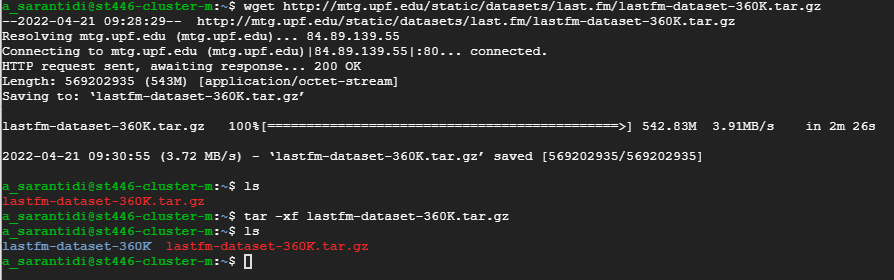

The two dataset were moved into Hadoop:

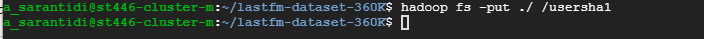

## Execution

In [90]:
#import the necessary libraries 
from pyspark.sql import SQLContext
import graphframes
from graphframes import *

from pyspark.sql.types import *
from pyspark.sql.functions import col, lit, when

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from time import time

In [3]:
# This is necessary for saving partial computations (checkpoints)
# Change to reflect your bucket name
sc.setCheckpointDir("gs://bucket-sar/tmp/") 

In [80]:
#Load the usersha1-profile.tsv dataset

folder = "hdfs:///usersha1/"  

# Schema for the dataset
schema = StructType([
    StructField("user-mboxsha1", StringType(), True),    
    StructField("gender", StringType(), True),
    StructField("age", LongType(), True),
    StructField("country", StringType(), True),
    StructField("signup", StringType(), True)
])

# loading the dataset
profile_df_org = spark.read.csv(folder +"usersha1-profile.tsv", header=True, schema=schema, sep='\t')
profile_df = profile_df_org.na.drop(how="any")

In [81]:
#Load the usersha1-artmbid-artname-plays.tsv dataset

# Schema for the dataset
schema = StructType([
    StructField("user-mboxsha1", StringType(), True),    
    StructField("musicbrainz-artist-id", StringType(), True),
    StructField("artist-name", StringType(), True),
    StructField("plays", LongType(), True)
])

# loading the dataset
play_df_org = spark.read.csv(folder +"usersha1-artmbid-artname-plays.tsv", header=True, schema=schema, sep='\t')
play_df = play_df_org.na.drop(how="any")


In [82]:
#Rename columns so that they don't have special characters
play_df = play_df.withColumnRenamed("musicbrainz-artist-id","mus_artist_id").\
withColumnRenamed("user-mboxsha1","user_id").\
withColumnRenamed("artist-name","artist_name")

profile_df = profile_df.withColumnRenamed("user-mboxsha1","user_id")

play_df.createOrReplaceTempView("play_df")
profile_df.createOrReplaceTempView("profile_df")

In [56]:
play_df.show(5)

+--------------------+--------------------+-------------+-----+
|             user_id|       mus_artist_id|  artist_name|plays|
+--------------------+--------------------+-------------+-----+
|001042d3aad1054f3...|4e0e884d-099b-4ca...|        duffy|   95|
|0077a05b7afffd9b7...|f795c501-1c41-4be...| gentle giant|   11|
|00c174068fbbc313c...|117a8255-3b06-433...|     jakalope|  182|
|00f29da0ebc18cf15...|d42fe2e7-c3dc-48e...|dinar bandosu|   46|
|013d38ecebfb7a9f0...|c80f38a6-9980-485...|   ryan adams|   51|
+--------------------+--------------------+-------------+-----+
only showing top 5 rows



In [126]:
profile_df.show(5)

+--------------------+------+---+--------------+------------+
|             user_id|gender|age|       country|      signup|
+--------------------+------+---+--------------+------------+
|000063d3fe1cf2ba2...|     m| 19|        Mexico|Apr 28, 2008|
|00007a47085b9aab8...|     m| 28| United States|Jan 27, 2006|
|0000c176103e538d5...|     m| 20|United Kingdom|Jan 14, 2006|
|0000ee7dd906373ef...|     m| 17|       Finland|Nov 17, 2007|
|0000ef373bbd0d89c...|     f| 22|        Poland|May 23, 2007|
+--------------------+------+---+--------------+------------+
only showing top 5 rows



In [84]:
#Get profile information into the play df:
play_prof_df = spark.sql("select a.*, b.gender, b.gender, b.age, b.country from play_df \
                            as a left join profile_df as b where a.user_id = b.user_id")
play_prof_df.createOrReplaceTempView("play_prof_df")

In [33]:
profile_df.count()

133602

In [39]:
play_df.select("user-mboxsha1").distinct().count()

359349

In [40]:
play_df.select("user-mboxsha1").count()

17559529

In [86]:
#Create a graph with no attributes

# establish edges and vertices
artist = play_df.select("artist_name").withColumnRenamed("artist_name","id").withColumn("role",lit("artist"))
user = play_df.select("user_id").withColumnRenamed("user_id","id").withColumn("role",lit("user"))

v = artist.union(user).distinct()
e = play_df.select("user_id","artist_name","plays")\
.withColumnRenamed("user_id","src").withColumnRenamed("artist_name","dst")


t0 = time()
g = GraphFrame(v, e) #Create the graph
t1 = time()
comp_time_g = (t1 - t0) #Calculate the computation time of building a graph
comp_time_g

0.008803129196166992

In [85]:
# Create a graph with attributes and weights:

# establish edges and vertices
artist_w = spark.sql("select artist_name as id,  '' as gender, null as age, '' as country, 'artist' as role from play_prof_df")
artist_w.createOrReplaceTempView("artist_w")

user_w = play_prof_df.select("user_id", "gender", "age", "country").withColumnRenamed("user_id","id").withColumn("role",lit("user"))

vw = artist_w.union(user_w).distinct()
ew = play_prof_df.select("user_id","artist_name","plays")\
.withColumnRenamed("user_id","src").withColumnRenamed("artist_name","dst").withColumnRenamed("plays","weight")


t0 = time()
gw = GraphFrame(vw, ew)  #Create the graph
t1 = time()
comp_time_gw = (t1 - t0) #Calculate the computation time of building a graph
comp_time_gw

0.0076520442962646484

In [81]:
v.show(5, truncate = False)

+------------------------------------+------+
|id                                  |role  |
+------------------------------------+------+
|157c092b-ec67-470a-a258-a4d455159a2e|artist|
|f2eef649-a6d5-4114-afba-e50ab26254d2|artist|
|45c6b878-48c5-48cf-ad48-4a7cf5a10787|artist|
|ea075268-e5ea-40f7-b9c3-68b039218a88|artist|
|f9c1cc73-36ba-4f8d-ba12-7d2490608886|artist|
+------------------------------------+------+
only showing top 5 rows



In [42]:
vw.show(5, truncate = False)

+----------------------------------------+------+----+-------+------+
|id                                      |gender|age |country|role  |
+----------------------------------------+------+----+-------+------+
|eels                                    |      |null|       |artist|
|18310da650556f66e0426898e9a913cfcffc7dac|f     |19  |Sweden |user  |
|362740d60cd302450de6ae41757487f48f2d7e76|m     |27  |Italy  |user  |
|7279b42ef5e44001879cfc3f3c6c8ad17bd835f1|f     |22  |Finland|user  |
|8ce7f9c79c0af5be8f50556576c3533165a4b92a|m     |25  |Finland|user  |
+----------------------------------------+------+----+-------+------+
only showing top 5 rows



In [43]:
ew.show(5, truncate = False)

+----------------------------------------+------------------+------+
|src                                     |dst               |weight|
+----------------------------------------+------------------+------+
|01093c1ca12f9f4beb5d69befb2022147e2a69b9|thomas newman     |87    |
|0198bcbfebfb08794535b2763096d8814ed8bf4f|the police        |39    |
|01eeac840eb68fde48f90eed03e99b93405e92b9|chad vangaalen    |79    |
|022ba0d1031ac132e1aa899559e393b33f4445bd|taking back sunday|370   |
|03a1e3708f1ce76bf39cec1f7ce80ac235ec8580|michael andrews   |19    |
+----------------------------------------+------------------+------+
only showing top 5 rows



## Most influential artist - PageRank

In [ ]:
# Determining ranking scores of artists using PageRank
computationTime_pr = np.zeros(1)
t0 = time()

ranks = g.pageRank(resetProbability=0.15, maxIter=3)

t1 = time()
computationTime_pr = (t1 - t0)
computationTime_pr

946.7985138893127

In [ ]:
#For weighted graph

# Determining ranking scores of artists using PageRank
computationTime_prw = np.zeros(1)
t0 = time()

ranksw = gw.pageRank(resetProbability=0.15, maxIter=3)

t1 = time()
computationTime_prw = (t1 - t0)
computationTime_prw

864.9986848831177

### The most important artists in terms of their influence

In [95]:
#Non-weighted graph
ranks.vertices.select("id", "pagerank").orderBy(ranks.vertices.pagerank.desc()).limit(10).show(10, truncate = False)

+---------------------+------------------+
|id                   |pagerank          |
+---------------------+------------------+
|radiohead            |863.0589461767735 |
|the beatles          |855.9524952068926 |
|coldplay             |755.7580597175711 |
|red hot chili peppers|556.7589781864452 |
|muse                 |530.9934376172165 |
|metallica            |515.1416222927016 |
|pink floyd           |497.9394656264087 |
|linkin park          |467.48710300398074|
|the killers          |462.8817883282724 |
|nirvana              |449.06797599335584|
+---------------------+------------------+



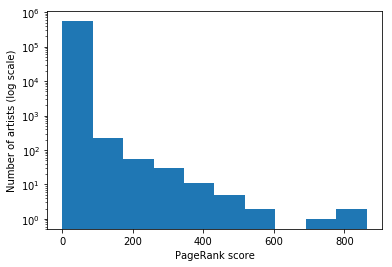

In [91]:
plt.hist(ranks.vertices.orderBy("pagerank").select("pagerank").rdd.flatMap(lambda x: x).collect(), bins=(10));
plt.ylabel('Number of artists (log scale)')
plt.xlabel('PageRank score');
plt.yscale('log')

In [94]:
#Weighted graph
ranksw.vertices.select("id", "pagerank").orderBy(ranksw.vertices.pagerank.desc()).show(10, truncate = False)

+---------------------+------------------+
|id                   |pagerank          |
+---------------------+------------------+
|radiohead            |659.6347388760202 |
|the beatles          |658.2181833634426 |
|coldplay             |586.3668110778707 |
|red hot chili peppers|446.7630069366572 |
|muse                 |431.9242738521465 |
|metallica            |421.1938022314983 |
|pink floyd           |389.37384710286847|
|linkin park          |386.13745919559597|
|the killers          |365.67722483988706|
|nirvana              |356.2079528102664 |
+---------------------+------------------+
only showing top 10 rows



## Top 10 most listened artists - the most famous artists

In [97]:
indeg= g.inDegrees #only artists have In Degrees
indeg.sort("inDegree", ascending=False).show(10, truncate = False)

+---------------------+--------+
|id                   |inDegree|
+---------------------+--------+
|radiohead            |77348   |
|the beatles          |76339   |
|coldplay             |66738   |
|red hot chili peppers|48989   |
|muse                 |47015   |
|metallica            |45301   |
|pink floyd           |44506   |
|the killers          |41280   |
|linkin park          |39833   |
|nirvana              |39534   |
+---------------------+--------+
only showing top 10 rows



### Top 5 users that listened to more artists

In [100]:
#Top 5 users that listen to more things
outdeg= g.outDegrees #only users have Out Degrees
outdeg.sort("outDegree", ascending=False).show(5, truncate = False)

+----------------------------------------+---------+
|id                                      |outDegree|
+----------------------------------------+---------+
|2040b3d3cb47caace19e728090a88d6b1087aa8e|165      |
|13c0df8a58cd3ca9e37d8e90662d2ad3c062eaa5|165      |
|52bf0682648b44e6cc27ebe512dd4fa3455a11c2|149      |
|7679da839e1a6c2d299c7fd6834fb9bf6e229224|138      |
|8d8643cded0ac18e66a3c5a2b74de21fbca0e6b7|131      |
+----------------------------------------+---------+
only showing top 5 rows



## Number of users per artist
We plot the complementary CDF (cumulative distribution fucntion) of the number of contributions per user in the log scale.

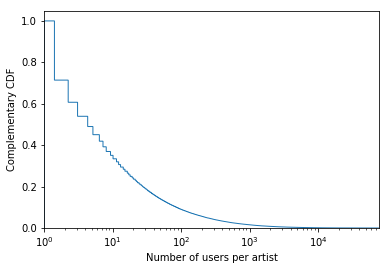

In [103]:
artists_by_user = indeg.select("inDegree").rdd.flatMap(lambda x: x).collect()
plt.hist(artists_by_user, bins=len(artists_by_user), density=1, histtype='step', cumulative=-1)

plt.xlabel('Number of users per artist')
plt.ylabel('Complementary CDF')
plt.xlim([min(artists_by_user),max(artists_by_user)])
plt.xscale('log')
plt.show()

## Similar taste artists - Motif

### All users

In [122]:
#find the pattern where a user is linked to 2 different artists
similar_taste_artists_all = gw.find("(u1)-[]->(a1); (u1)-[]->(a2)")\
                        .filter("a1.id != a2.id")

In [123]:
#Get the 2 artist names into 1 column, so that they form a pair. Make sure that they are stored in alphabetic order
# within their pair. Get distinct rows.

similar_taste_artists_all.createOrReplaceTempView("similar_taste_artists_all")
similar_taste_artists_all2 = spark.sql("select distinct u1.id, (greatest(a1.id, a2.id), least(a1.id, a2.id)) as grp_artists from similar_taste_artists_all")
similar_taste_artists_all2.createOrReplaceTempView("similar_taste_artists_all2")

In [ ]:
#Count the number of times that a pair of artists was seen
similar_taste_artists_all3 = spark.sql("select grp_artists, count(*) as grp_cnt from similar_taste_artists_all2 group by grp_artists order by count(*) desc")
similar_taste_artists_all3.createOrReplaceTempView("similar_taste_artists_all3")
similar_taste_artists_all3.show(10, truncate = False)

+---------------------------------+-------+
|grp_artists                      |grp_cnt|
+---------------------------------+-------+
|[the beatles, radiohead]         |21847  |
|[radiohead, coldplay]            |19823  |
|[radiohead, muse]                |16503  |
|[the beatles, pink floyd]        |15764  |
|[the beatles, coldplay]          |15726  |
|[the killers, coldplay]          |15447  |
|[muse, coldplay]                 |14630  |
|[red hot chili peppers, coldplay]|13583  |
|[the beatles, bob dylan]         |13261  |
|[the beatles, led zeppelin]      |12773  |
+---------------------------------+-------+
only showing top 10 rows



### Users from Italy

In [104]:
#find the pattern where a user is linked to 2 different artists and the user is from the country Italy.
similar_taste_artists = gw.find("(u1)-[]->(a1); (u1)-[]->(a2)")\
                        .filter("a1.id != a2.id")\
                        .filter("u1.country = 'Italy'")

In [105]:
similar_taste_artists.show(4, truncate = False)

+--------------------------------------------------------------+-------------------------------+-------------------------------+
|u1                                                            |a1                             |a2                             |
+--------------------------------------------------------------+-------------------------------+-------------------------------+
|[98d27e26a3ffe8d8355962ecee70c340f94563be, m, 23, Italy, user]|[sufjan stevens, ,, , artist]  |[a toys orchestra, ,, , artist]|
|[98d27e26a3ffe8d8355962ecee70c340f94563be, m, 23, Italy, user]|[the notwist, ,, , artist]     |[a toys orchestra, ,, , artist]|
|[98d27e26a3ffe8d8355962ecee70c340f94563be, m, 23, Italy, user]|[sigur rós, ,, , artist]       |[a toys orchestra, ,, , artist]|
|[98d27e26a3ffe8d8355962ecee70c340f94563be, m, 23, Italy, user]|[acid house kings, ,, , artist]|[a toys orchestra, ,, , artist]|
+--------------------------------------------------------------+-------------------------------+-

In [116]:
similar_taste_artists.createOrReplaceTempView("similar_taste_artists")
similar_taste_artists2 = spark.sql("select distinct u1.id, (greatest(a1.id, a2.id), least(a1.id, a2.id)) as grp_artists from similar_taste_artists")
similar_taste_artists2.createOrReplaceTempView("similar_taste_artists2")

In [117]:
similar_taste_artists3 = spark.sql("select grp_artists, count(*) as grp_cnt from similar_taste_artists2 group by grp_artists order by count(*) desc")
similar_taste_artists3.createOrReplaceTempView("similar_taste_artists3")
similar_taste_artists3.show(10, truncate = False)

+------------------------------------+-------+
|grp_artists                         |grp_cnt|
+------------------------------------+-------+
|[the beatles, radiohead]            |582    |
|[radiohead, coldplay]               |575    |
|[the beatles, pink floyd]           |568    |
|[radiohead, afterhours]             |526    |
|[radiohead, pink floyd]             |525    |
|[franco battiato, fabrizio de andré]|520    |
|[the beatles, fabrizio de andré]    |512    |
|[pink floyd, fabrizio de andré]     |489    |
|[radiohead, fabrizio de andré]      |488    |
|[radiohead, muse]                   |449    |
+------------------------------------+-------+
only showing top 10 rows



### Users from Sweden

In [119]:
#find the pattern where a user is linked to 2 different artists and the user is from Sweden.
similar_taste_artists_sw = gw.find("(u1)-[]->(a1); (u1)-[]->(a2)")\
                        .filter("a1.id != a2.id")\
                        .filter("u1.country = 'Sweden'")

In [120]:
similar_taste_artists_sw.createOrReplaceTempView("similar_taste_artists_sw")
similar_taste_artists_sw2 = spark.sql("select distinct u1.id, (greatest(a1.id, a2.id), least(a1.id, a2.id)) as grp_artists from similar_taste_artists_sw")
similar_taste_artists_sw2.createOrReplaceTempView("similar_taste_artists_sw2")

In [121]:
similar_taste_artists_sw3 = spark.sql("select grp_artists, count(*) as grp_cnt from similar_taste_artists_sw2 group by grp_artists order by count(*) desc")
similar_taste_artists_sw3.createOrReplaceTempView("similar_taste_artists_sw3")
similar_taste_artists_sw3.show(10, truncate = False)

+----------------------------------+-------+
|grp_artists                       |grp_cnt|
+----------------------------------+-------+
|[kent, coldplay]                  |1082   |
|[the killers, coldplay]           |993    |
|[kent, håkan hellström]           |869    |
|[lars winnerbäck, kent]           |833    |
|[the killers, kent]               |794    |
|[metallica, in flames]            |733    |
|[håkan hellström, coldplay]       |729    |
|[lars winnerbäck, coldplay]       |725    |
|[the beatles, bob dylan]          |657    |
|[lars winnerbäck, håkan hellström]|652    |
+----------------------------------+-------+
only showing top 10 rows

